In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import itertools
import pickle

In [2]:
## data preprocess
task1=pd.read_csv('task1_dataset.csv')
traj_uid={}
last_day=0
last_uid=0
traj_day=[]
count=0
for idx in range(task1.size):
    record=task1.loc[idx] #uid ,day,hour,x,y
    uid=record[0]
    day=record[1]
    hour=record[2]
    (x,y)=(record[3],record[4])
    if count>20000:  # select user num
        break
    if uid not in traj_uid.keys():
        if count%500==0:
            print(uid, end=' ')
        count+=1
        if count>20000:
            break
        traj_uid[uid]=[]
    if day!=last_day:
        if last_uid==uid:
            traj_uid[uid].append(traj_day)
            traj_day=[]
        else:
            traj_uid[last_uid].append(traj_day)
            traj_day=[]

    traj_day.append((day,hour,(x,y))) 
    last_day=day
    last_uid=uid

0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 5500 6000 6500 7000 7500 8000 8500 9000 9500 10000 10500 11000 11500 12000 12500 13000 13500 14000 14500 15000 15500 16000 16500 17000 17500 18000 18500 19000 19500 20000 

In [4]:
pickle.dump(traj_uid, open('task1/traj_uid_raw.pkl', 'wb'))
traj_uid=pickle.load( open('task1/traj_uid_raw.pkl','rb'))

In [3]:
traj_target={}
for k in tqdm(traj_uid.keys()):
    traj_target[k]=[]
    trajs=traj_uid[k]
    for traj in trajs:
        loc_seq=[]
        tim_seq=[]
        for record in traj:
            loc=record[2]
            hour=record[1]
            loc_seq.append(loc)
            tim_seq.append(hour)
        traj_target[k].append((loc_seq,tim_seq))

100%|██████████| 20000/20000 [00:10<00:00, 1901.49it/s]


In [4]:
loc_all=set()
for uid in traj_uid.keys():
    for traj in traj_uid[uid]:
        for record in traj:
            loc=record[-1]
            loc_all.add(loc)
loc_all=sorted(list(loc_all))
loc2id={}
id2loc={}
for i in range(len(loc_all)): # mask 0
    loc2id[loc_all[i]]=i+1
    id2loc[i+1]=loc_all[i]
print('max loc',max(loc2id.values()),'min loc',min(loc2id.values()))
max_loc=max(loc2id.values())  #task1:max loc 29169 min loc 1  task2:max loc 29533 min loc 1
min_loc=min(loc2id.values())
pickle.dump(id2loc, open('task1/MIT_loccor.pkl', 'wb')) #{userid:home id}
id2loc=pickle.load( open('task1/MIT_loccor.pkl','rb'))
sos=max_loc+2
eos=max_loc+1
print(sos,eos) #task1:29171 29170  task2:29535 29534

max loc 29169 min loc 1
29171 29170


In [5]:
## find user home
from collections import Counter
user_traj_hour={}
user_home={}
for uid in traj_uid.keys():
    user_traj_hour[uid]={}
    for i in range(48):
        user_traj_hour[uid][i]=[]
    for traj in traj_uid[uid]:
        for record in traj:
            hour=record[1]
            locid=loc2id[record[-1]]
            user_traj_hour[uid][hour].append(locid)
    for hour in user_traj_hour[uid].keys():
        if len(user_traj_hour[uid][hour])!=0:
            most_com_loc=Counter(user_traj_hour[uid][hour]).most_common()[0][0]
            user_home[uid]=most_com_loc
            break
pickle.dump(user_home, open('task1/MIT_attr_home.pkl', 'wb')) #{userid:home id}

In [6]:
## traj to length 48 and loc to id
traj_uid_new={}
for uid in list(traj_uid.keys())[:]:
    traj_uid_new[uid]=[]
    for traj in traj_uid[uid]:
        traj_new=[]
        for i in range(len(traj)):
            hour=traj[i][1]
            locid=loc2id[traj[i][-1]]
            if i==0:
                for j in range(0,hour):
                    traj_new.append(user_home[uid])
            if i==len(traj)-1:
                 for j in range(hour,48):
                    traj_new.append(locid)
            if i>=0 and i<len(traj)-1:
                hour_n=traj[i+1][1]
                for j in range(hour,hour_n):
                    traj_new.append(locid)
        assert len(traj_new)==48
        traj_uid_new[uid].append(traj_new)
pickle.dump(traj_uid_new, open('task1/MIT_traj.pkl', 'wb'))

In [7]:
MIT_traj_split={}
MIT_mask_traj={}
MIT_mask_day={}
for uid in tqdm(list(traj_uid_new.keys())[:]):
    locs=[]
    tims=[]
    MIT_mask_traj[uid]=[]
    MIT_mask_day[uid]=[]
    for i in range(len(traj_uid_new[uid])):
        traj=traj_uid_new[uid][i]
        MIT_mask_day[uid].append(0)
        traj_unique=[sos]
        mask_list=[0]
        tim_list=[]
        for loc,d in itertools.groupby(traj):
            traj_unique.append(loc)
            mask_list.append(0)
            tim_list.append(len(list(d)))
        traj_unique.append(eos)
        mask_list.append(0)
        loc_unique_count=len(traj_unique)-2
        for j in range(len(traj_unique),48+2):
            traj_unique.append(0)
            mask_list.append(1)
        assert len(tim_list)==loc_unique_count
        assert sum(tim_list)==48
        for j in range(len(tim_list),48):
            tim_list.append(0)
        assert len(tim_list)==48
        locs.append(traj_unique)
        tims.append(tim_list)
        MIT_mask_traj[uid].append(mask_list)
    MIT_traj_split[uid]={}
    MIT_traj_split[uid]['loc']=locs
    MIT_traj_split[uid]['tim']=tims
pickle.dump(MIT_traj_split, open('task1/MIT_traj_split.pkl', 'wb'))
pickle.dump(MIT_mask_traj, open('task1/MIT_mask_traj.pkl', 'wb'))
pickle.dump(MIT_mask_day, open('task1/MIT_mask_day.pkl', 'wb'))

100%|██████████| 20000/20000 [00:20<00:00, 957.81it/s] 


In [8]:
def get_batch_info_week(uid_traj, win_len, uid_mask_day, split=[0.9, 0.1, 0.0]):
    batch_all = {'train': [], 'valid': [], 'test': []}

    for uid, traj_all in uid_traj.items():
        traj_num = len(traj_all['loc'])
        if uid<16000:   # task1 ,we select 20000 users,and 16000-19999 for test 
            batch_all['valid'] += [(uid, traj_num-win_len-15)]
        elif uid>=16000:
            batch_all['test'] += [(uid, traj_num-win_len-15)]
    print(
        f'Trajectory Number: train/valid/test: {len(batch_all["train"])}/{len(batch_all["valid"])}/{len(batch_all["test"])}')
    return batch_all

In [66]:
#most_frequent_loc code
def most_frequent_loc(task,mode):
    if task==1:
        dataset='task1'
    else:
        dataset='task2'
    uid_traj_split = pickle.load(open(f'./{dataset}/MIT_traj_split.pkl', 'rb'))
    uid_traj = pickle.load(open(f'./{dataset}/MIT_traj.pkl', 'rb'))
    uid_mask_day = pickle.load(open(f'./{dataset}/MIT_mask_day.pkl', 'rb'))
    loc_coor = pickle.load(open(f'./{dataset}/MIT_loccor.pkl', 'rb'))

    batch_all = get_batch_info_week(uid_traj_split, 7, uid_mask_day)[mode]
    batch_list = batch_all[:]
    week = 15
    his=7
    traj_week = [{} for i in range(week)]  # 
    traj_week_true = [{} for i in range(week)]
    for uid, traj_start in tqdm(batch_list):
        for i in range(week):
            if uid not in traj_week[i].keys():
                traj_week[i][uid] = []
                traj_week_true[i][uid] = []
        trajs_his = []
        for i in range(his):
            if uid_mask_day[uid][traj_start + i] == 0:
                trajs_his.append(uid_traj[uid][traj_start + i])
        trajs_his_current = trajs_his
        for i in range(week):
            traj_day = []
            if len(trajs_his_current) >= his:
                trajs_his_current = trajs_his_current[-his:]
            for h in range(0, 48):
                traj_hour = []
                for traj in trajs_his_current:
                    traj_hour.append(traj[h])
                commen_loc = Counter(traj_hour).most_common()
                most_loc = commen_loc[0][0]
                traj_day.append(most_loc)
            traj_week[i][uid].append(traj_day)
            traj_week_true[i][uid].append(uid_traj[uid][traj_start + his + i])
            trajs_his_current.append(traj_day)
            if len(traj_week_true[i][uid]) == 0:
                del traj_week[i][uid]
                del traj_week_true[i][uid]
    pickle.dump(traj_week, open(f'./task1/mfl_15_task{task}.pkl', 'wb'))
    pickle.dump(traj_week_true, open(f'./task1/mfl_15_task{task}_true.pkl', 'wb'))

In [74]:
h

47

In [148]:
task=1
mode='test'
if task==1:
    dataset='task1'
else:
    dataset='task2'
uid_traj_split = pickle.load(open(f'./{dataset}/MIT_traj_split.pkl', 'rb'))
uid_traj = pickle.load(open(f'./{dataset}/MIT_traj.pkl', 'rb'))
uid_mask_day = pickle.load(open(f'./{dataset}/MIT_mask_day.pkl', 'rb'))
loc_coor = pickle.load(open(f'./{dataset}/MIT_loccor.pkl', 'rb'))

batch_all = get_batch_info_week(uid_traj_split, 7, uid_mask_day)[mode]
batch_list = batch_all[:]
week = 15
his=7
traj_week = [{} for i in range(week)]  # 
traj_week_true = [{} for i in range(week)]
for uid, traj_start in tqdm(batch_list):
    for i in range(week):
        if uid not in traj_week[i].keys():
            traj_week[i][uid] = []
            traj_week_true[i][uid] = []
    trajs_his = []
    for i in range(his):
        if uid_mask_day[uid][traj_start + i] == 0:
            trajs_his.append(uid_traj[uid][traj_start + i])
    trajs_his_current = trajs_his

    for i in range(week):
        traj_day = []
        if len(trajs_his_current) >= his:
            trajs_his_current = trajs_his_current[-his:]
        for h in range(0, 48):
            traj_hour = []
            for traj in trajs_his_current:
                binary = (np.array(traj) == user_home[uid])
                start_of_the_day = np.where(binary == False)[0]
                # if start_of_the_day < h:
                if (h < 2) | (h > 45):
                    traj_hour.append(traj[h])
                else:
                    traj_hour.append(traj[h-1])
                    traj_hour.append(traj[h-2])
                    traj_hour.append(traj[h])
                    traj_hour.append(traj[h+1])
                    traj_hour.append(traj[h+2])
                # else:

                #     traj_hour.append(traj[start_of_the_day])
                #     start_of_the_day += 1
            commen_loc = Counter(traj_hour).most_common()
            most_loc = commen_loc[0][0]
            traj_day.append(most_loc)
        traj_week[i][uid].append(traj_day)
        traj_week_true[i][uid].append(uid_traj[uid][traj_start + his + i])
        trajs_his_current.append(traj_day)
        if len(traj_week_true[i][uid]) == 0:
            del traj_week[i][uid]
            del traj_week_true[i][uid]


Trajectory Number: train/valid/test: 0/16000/4000


100%|██████████| 4000/4000 [01:55<00:00, 34.63it/s]


In [10]:
most_frequent_loc(1,'test')

Trajectory Number: train/valid/test: 0/16000/4000


100%|██████████| 4000/4000 [00:05<00:00, 735.46it/s]


In [149]:
pickle.dump(traj_week, open(f'./task1/mfl_16_task{task}.pkl', 'wb'))
pickle.dump(traj_week_true, open(f'./task1/mfl_16_task{task}_true.pkl', 'wb'))

In [145]:
## calculate the entropy of users
MIT_traj=pickle.load( open('task1/MIT_traj.pkl','rb'))
entropy={}
for user in range(16000,20000):  #task1:16000-19999 for test
    loc_list=[]
    seqs=MIT_traj[user]
    for seq in seqs:
        loc_list.append(np.log(len(set(seq))))
    entropy[user]=round(sum(loc_list)/len(loc_list),1)

In [167]:
## calcuate predict precision 
traj_tru=pickle.load( open('task1/mfl_15_task1_true.pkl','rb'))
traj_nyc_mfl=pickle.load( open('task1/mfl_15_task1.pkl','rb'))
precision_user_mfl={}
for d in range(1):  # just calculate the first day precision
    for k in traj_nyc_mfl[d].keys():
        if k not in precision_user_mfl.keys():
            precision_user_mfl[k]=[0 for i in range(1)]
        traj_true=np.array(traj_tru[d][k][0])
        traj=np.array(traj_nyc_mfl[d][k][0])
        prec_d=sum(traj==traj_true)/len(traj)
        precision_user_mfl[k][d]=prec_d
for k in precision_user_mfl.keys():
    precision_user_mfl[k]=sum(precision_user_mfl[k])/len(precision_user_mfl[k])

In [165]:
a = []
for k in precision_user_mfl.keys():
    a.append(precision_user_mfl[k])
a = np.array(a)

In [168]:
b = []
for k in precision_user_mfl.keys():
    b.append(precision_user_mfl[k])
b = np.array(b)

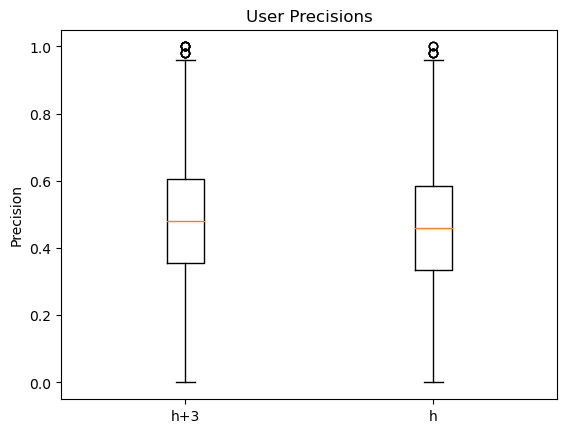

In [178]:
data = [a, b]

# Create a figure and axis
fig, ax = plt.subplots()

# Create the boxplot
ax.boxplot(data)

# Customize the plot (optional)
ax.set_xticklabels(['h+3', 'h'])
ax.set_ylabel('Precision')
ax.set_title('User Precisions')

# Show the plot
plt.show()

In [174]:
a

array([0.35416667, 0.6875    , 0.66666667, ..., 0.75      , 0.41666667,
       0.22916667])

In [161]:
precision_user_mfl

{16000: 0.3541666666666667,
 16001: 0.6875,
 16002: 0.6666666666666666,
 16003: 0.5,
 16004: 0.6875,
 16005: 0.0625,
 16006: 0.20833333333333334,
 16007: 0.3541666666666667,
 16008: 0.5208333333333334,
 16009: 0.5208333333333334,
 16010: 0.5,
 16011: 0.5416666666666666,
 16012: 0.125,
 16013: 0.3958333333333333,
 16014: 0.08333333333333333,
 16015: 0.4166666666666667,
 16016: 0.6666666666666666,
 16017: 0.375,
 16018: 0.3333333333333333,
 16019: 0.7916666666666666,
 16020: 0.5,
 16021: 0.4375,
 16022: 0.5833333333333334,
 16023: 0.625,
 16024: 0.4791666666666667,
 16025: 0.5,
 16026: 0.5208333333333334,
 16027: 0.6041666666666666,
 16028: 0.3541666666666667,
 16029: 0.2916666666666667,
 16030: 0.5625,
 16031: 0.3125,
 16032: 0.5416666666666666,
 16033: 0.3541666666666667,
 16034: 0.4166666666666667,
 16035: 0.4583333333333333,
 16036: 0.3958333333333333,
 16037: 0.7916666666666666,
 16038: 0.4166666666666667,
 16039: 0.8541666666666666,
 16040: 0.375,
 16041: 0.6041666666666666,
 16042

In [151]:
#计算entropy各个值对应的precision的平均值，将entropy区间定义为[0.0,5.0],按0.2划分一个区间，所以是25个单位
y_mfl=[[] for i in range(25)]   
for user in precision_user_mfl.keys():
    value=precision_user_mfl[user]
    etp=entropy[user]
    idx=int(etp*5)
    y_mfl[idx].append(value)
y_mfl=y_mfl[3:16]  #【0.6，3.3】映射到【0，25】是【3：16】
for i in range(len(y_mfl)):
    y_mfl[i]=sum(y_mfl[i])/len(y_mfl[i])
y_mfl

[0.7239583333333333,
 0.5972222222222222,
 0.7777777777777778,
 0.6225961538461539,
 0.5935077519379842,
 0.5804354636591478,
 0.529668898809524,
 0.5065652044165927,
 0.45282815198618254,
 0.40511133603238875,
 0.3809012875536478,
 0.3370462046204621,
 0.23161764705882354]

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
def entropy_precision():
    plt.figure(figsize=(5, 3), dpi=300)
   
    linewidth = 2
    markersize = 6
    x=[i/10. for i in range(0,50,2)][3:16]
    plt.plot(x, y_mfl, c='#e20404',  label='Most freq loc',linestyle='solid')

    plt.legend(fontsize=10, edgecolor='#CCCCCC')
    plt.title("Relationship between entropy and 1st day prediction accuracy on Task1", fontsize=10,y=-0.33)
    plt.xlabel("Human Mobility Entropy", fontsize=8)
    plt.ylabel("Precision@1", fontsize=8)

    plt.xticks([i/10. for i in range(0,50,2)][4:15], fontsize=10)

    ax = plt.gca()
    ax.spines['right'].set_edgecolor('none')
    ax.spines['top'].set_edgecolor('none')
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    plt.show()

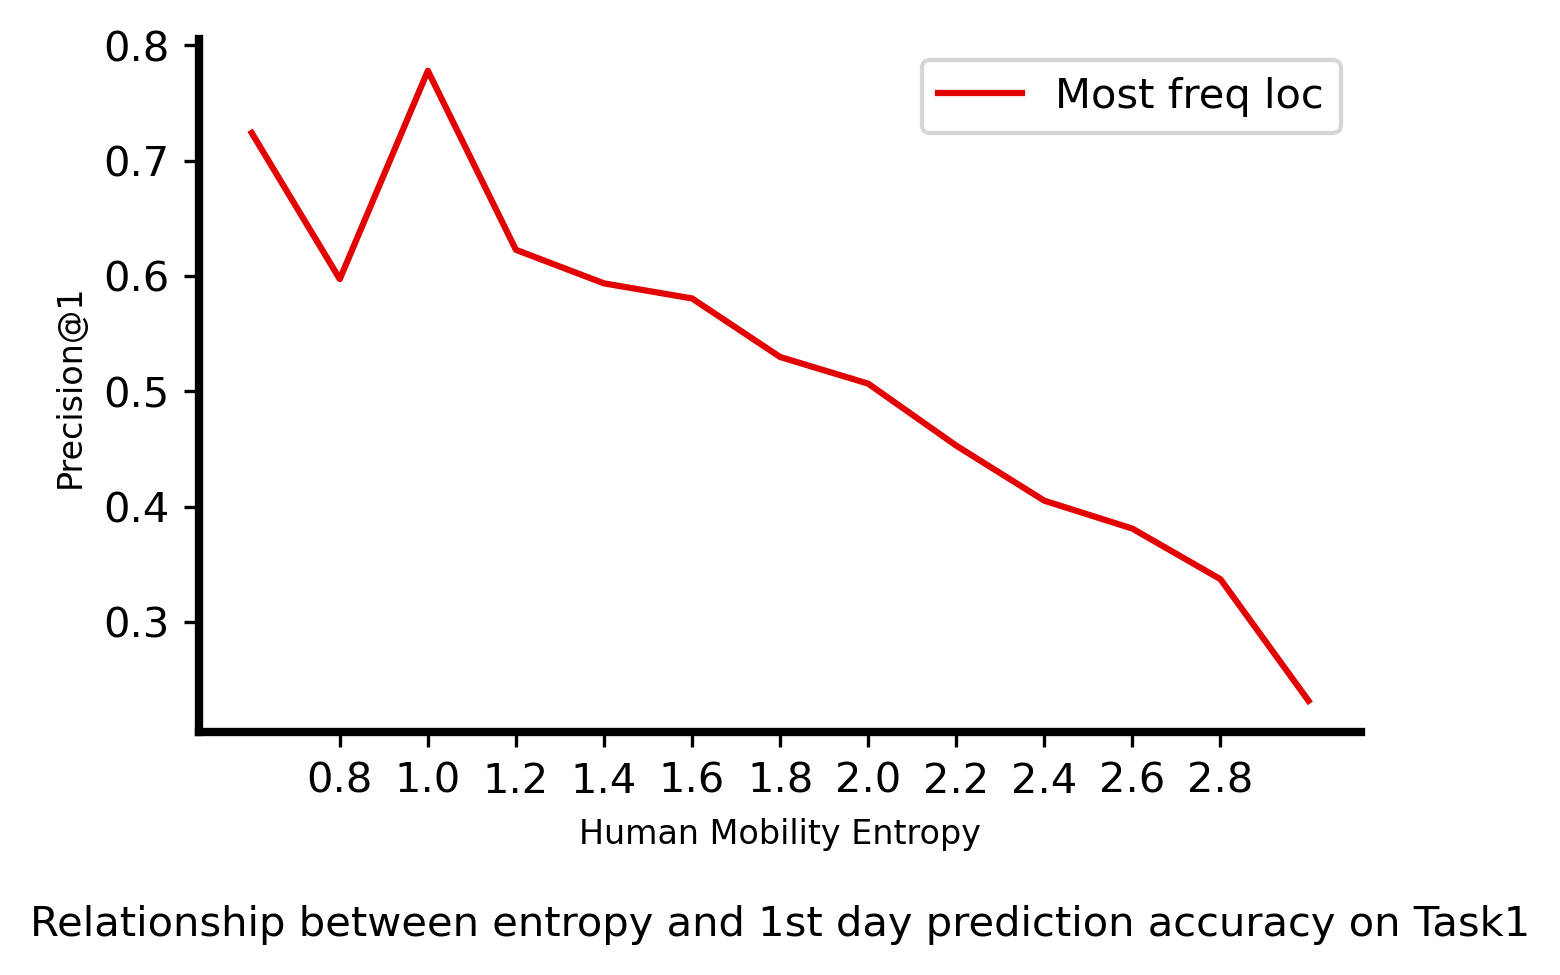

In [154]:
entropy_precision()

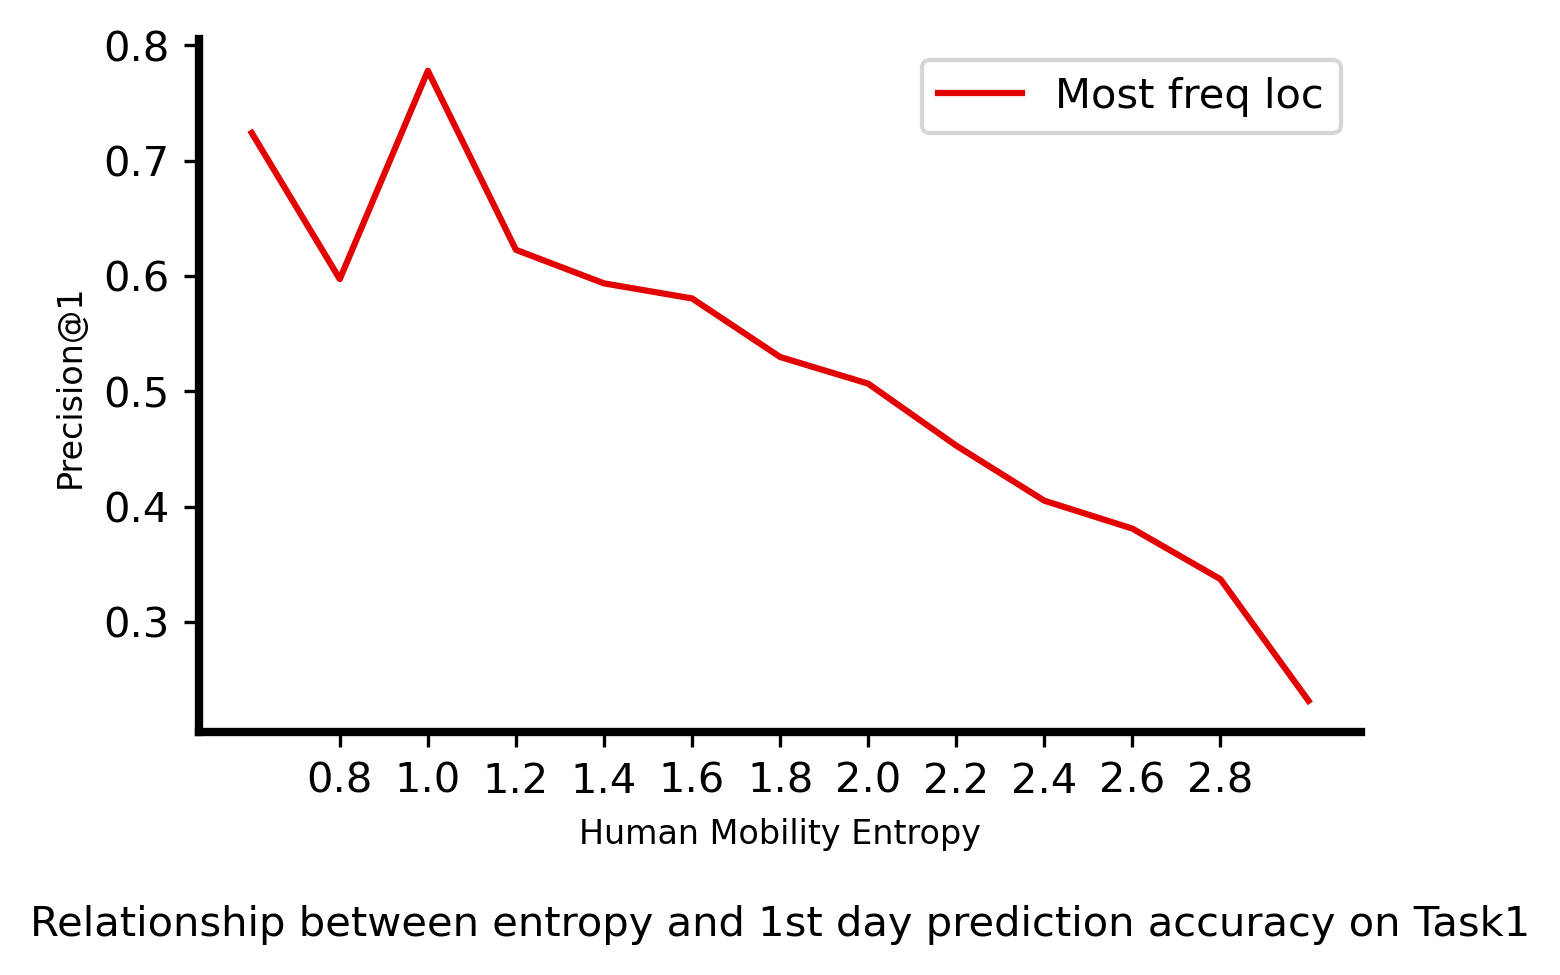

In [152]:
entropy_precision()